In [2]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [42]:
data = []
results_dir = 'results'
for f_name in os.listdir(results_dir):
    if f_name.endswith('.jsonl'):
        with open(os.path.join(results_dir, f_name)) as f:
            for line in f:
                if line.strip():
                    data.append(json.loads(line))
results_dir = '.'
for f_name in os.listdir(results_dir):
    if f_name.endswith('.jsonl'):
        with open(os.path.join(results_dir, f_name)) as f:
            for line in f:
                if line.strip():
                    data.append(json.loads(line))

In [43]:
for d in data:
    assert d['task_num'] == d['info']['task_num']

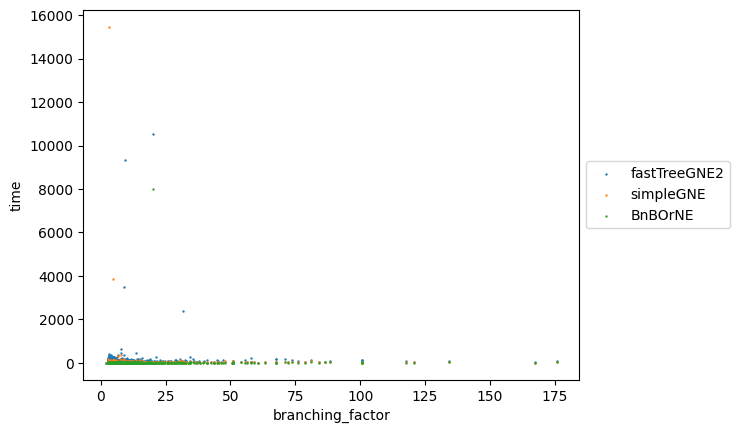

In [24]:

algorithms = [
    # 'random_solution',
    # 'treeGNE', 
    # 'treeGNE2', 
    'fastTreeGNE2', 
    'simpleGNE', 
    # 'AOsearchGNE', 
    # 'OrNE', 
    'BnBOrNE', 
    # 'BnBOrNEskip'
]


all_values = {}
for d in data:
    try:
        determiner_value = d['tree_info']['branching_factor']
    except:
        continue
    upper_bound = d['upper_bound']
    for algorithm in algorithms:
        value = d[algorithm]['time']
        all_values[algorithm] = all_values.get(algorithm, {})
        all_values[algorithm][determiner_value] = all_values[algorithm].get(determiner_value, [])
        all_values[algorithm][determiner_value].append(value)

for algorithm, array in all_values.items():
    for determiner_value, arr in array.items():
        array[determiner_value] = np.mean(arr)


for algorithm, array in all_values.items():
    array = dict(sorted(array.items()))
    # plt.plot(list(array.keys()), list(array.values()), label=algorithm)
    plt.scatter(list(array.keys()), list(array.values()), label=algorithm, s=0.5)
plt.legend()
plt.xlabel('branching_factor')
plt.ylabel('time')


# Put the legend to the right of the chart
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


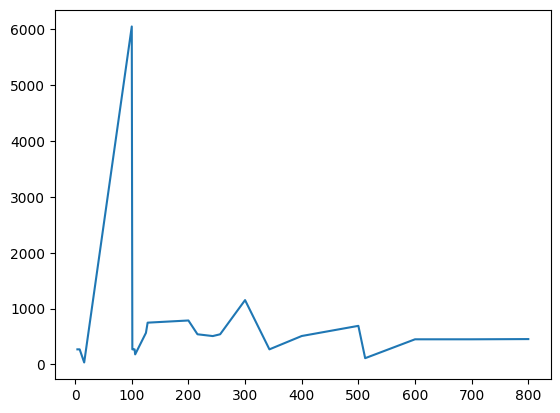

In [44]:
task_nums = sorted([d['task_num'] for d in data])
# Groupby count
task_num_counts = {}
for task_num in task_nums:
    task_num_counts[task_num] = task_num_counts.get(task_num, 0) + 1
# task_num_counts = dict(sorted(task_num_counts.items()))

plt.plot(list(task_num_counts.keys()), list(task_num_counts.values()), label='task_num_counts')

Text(0.5, 1.0, 'branching_factor^max_depth vs BnBOrNE time')

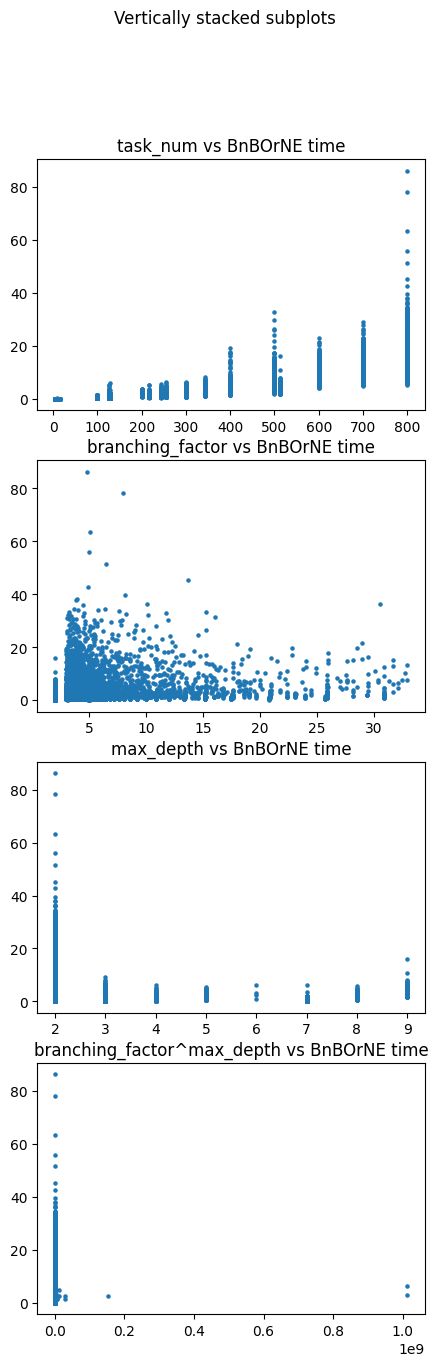

In [54]:
x_task_num = [d['task_num'] for d in data if 'tree_info' in d]
x_branching_factor = [d['tree_info']['branching_factor'] for d in data if 'tree_info' in d]
x_max_depth = [d['tree_info']['max_depth'] for d in data if 'tree_info' in d]
x = [d['tree_info']['branching_factor']**d['tree_info']['max_depth'] for d in data if 'tree_info' in d]
y = [d['BnBOrNE']['time'] for d in data if 'tree_info' in d]
x_task_num = np.array(x_task_num)
x_branching_factor = np.array(x_branching_factor)
x_max_depth = np.array(x_max_depth)
x = np.array(x)
y = np.array(y)
# mask = np.abs(stats.zscore(y)) < 3 and np.abs(stats.zscore(x)) < 3
zy = np.abs(stats.zscore(y))
zx = np.abs(stats.zscore(x))
zx_task_num = np.abs(stats.zscore(x_task_num))
zx_branching_factor = np.abs(stats.zscore(x_branching_factor))
zx_max_depth = np.abs(stats.zscore(x_max_depth))
mask = (zy < 2) & (zx < 3) & (zx_task_num < 3) & (zx_branching_factor < 3) & (zx_max_depth < 3)
x = x[mask]
y = y[mask]
x_task_num = x_task_num[mask]
x_branching_factor = x_branching_factor[mask]
x_max_depth = x_max_depth[mask]

# Create multiple subplots
fig, axs = plt.subplots(4, 1, figsize=(5, 15))
fig.suptitle('Vertically stacked subplots')
axs[0].scatter(x_task_num, y, s=5)
axs[0].set_title('task_num vs BnBOrNE time')
axs[1].scatter(x_branching_factor, y, s=5)
axs[1].set_title('branching_factor vs BnBOrNE time')
axs[2].scatter(x_max_depth, y, s=5)
axs[2].set_title('max_depth vs BnBOrNE time')
axs[3].scatter(x, y, s=5)
axs[3].set_title('branching_factor^max_depth vs BnBOrNE time')
# plt.scatter(x, y, label='BnBOrNE time vs branching_factor^max_depth', s=5)

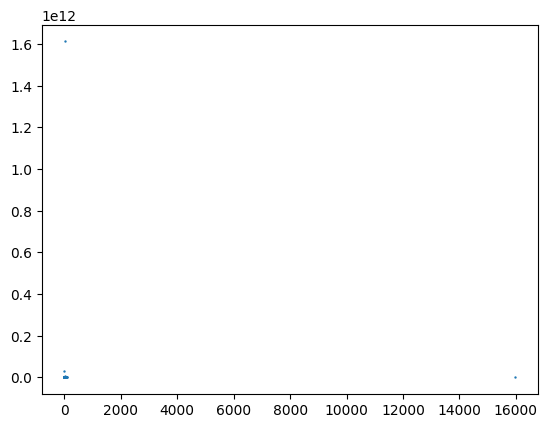

In [ ]:
{
    "task_num": 128,
    "tree_info": {
        "max_depth": 7,
        "min_depth": 7,
        "branching_factor": 2.0,
        "min_degree": 2,
        "max_degree": 2,
        "num_internal_nodes": 127,
    },
    "upper_bound": 592,
    "random_solution": {"reward": 292, "time": 0.013374300033319741},
    "treeGNE": {
        "reward": 577,
        "time": 0.6030290999915451,
        "iteration": 41,
        "re-assignment": 0,
    },
    "fastTreeGNE2": {
        "reward": 577,
        "time": 3.304753799980972,
        "iteration": 271,
        "re-assignment": 19,
    },
    "simpleGNE": {
        "reward": 564,
        "time": 1.9341076000127941,
        "iteration_1": 758,
        "re-assignment_1": 91,
        "iteration_2": 67,
        "re-assignment_2": 1,
        "loop": 3,
    },
    "BnBOrNE": {
        "reward": 577,
        "time": 1.294037899991963,
        "iteration": 561,
        "re-assignment": 35,
    },
    "info": {
        "ex_identifier": 2,
        "task_num": 128,
        "agent_num": 256,
        "capNum": 10,
        "up": 6196,
        "up2": 6191,
        "a_den_avg": 4.99609375,
        "a_den_max": 10,
        "a_den_min": 1,
        "t_den_avg": 9.9921875,
        "t_den_max": 10,
        "t_den_min": 9,
        "t_max_edge": 10,
        "g": 5311,
        "g_iter": 271,
        "g_reass": 20,
        "g_t": 0.9035366999451071,
    },
}

In [ ]:
{
    "task_num": 500,
    "tree_info": {
        "max_depth": 2,
        "min_depth": 2,
        "branching_factor": 3.376190476190476,
        "min_degree": 2,
        "max_degree": 209,
        "num_internal_nodes": 210,
    },
    "upper_bound": 24864,
    "random_solution": {"reward": 7802, "time": 0.11868389998562634},
    "treeGNE": {
        "reward": 23179,
        "time": 48.779179799952544,
        "iteration": 1139,
        "re-assignment": 73,
    },
    "treeGNE2": {
        "reward": 23301,
        "time": 103.63403219997417,
        "iteration": 1971,
        "re-assignment": 179,
    },
    "fastTreeGNE2": {
        "reward": 23301,
        "time": 36.41690469998866,
        "iteration": 1971,
        "re-assignment": 179,
    },
    "simpleGNE": {
        "reward": 23393,
        "time": 25.214789899997413,
        "iteration_1": 4721,
        "re-assignment_1": 1183,
        "iteration_2": 1257,
        "re-assignment_2": 130,
        "loop": 4,
    },
    "AOsearchGNE": {
        "reward": 19172,
        "time": 133.24300409993157,
        "iteration": 2199,
        "re-assignment": 231,
        "loop": 2,
    },
    "OrNE": {
        "reward": 23345,
        "time": 9.26101519993972,
        "iteration": 2444,
        "re-assignment": 199,
    },
    "BnBOrNE": {
        "reward": 23345,
        "time": 10.071934700012207,
        "iteration": 2444,
        "re-assignment": 199,
    },
    "BnBOrNEskip": {
        "reward": 23345,
        "time": 9.812757199979387,
        "iteration": 2444,
        "re-assignment": 199,
    },
    "info": {
        "ex_identifier": 781,
        "task_num": 500,
        "agent_num": 2000,
        "capNum": 13,
        "up": 45945,
        "up2": 45759,
        "a_den_avg": 3.9995,
        "a_den_max": 16,
        "a_den_min": 1,
        "t_den_avg": 15.998,
        "t_den_max": 16,
        "t_den_min": 15,
        "t_max_edge": 16,
        "g": 41908,
        "g_iter": 1873,
        "g_reass": 142,
        "g_t": 30.781984800007194,
    },
}

In [ ]:
{
    "task_num": 100,
    "upper_bound": 1605,
    "random_solution": {"reward": 486, "time": 0.003914499975508079},
    "treeGNE": {
        "reward": 1519,
        "time": 0.1602038000128232,
        "iteration": 96,
        "re-assignment": 2,
    },
    "treeGNE2": {
        "reward": 1519,
        "time": 0.38037139998050407,
        "iteration": 208,
        "re-assignment": 8,
    },
    "fastTreeGNE2": {
        "reward": 1519,
        "time": 0.2184568999800831,
        "iteration": 208,
        "re-assignment": 8,
    },
    "simpleGNE": {
        "reward": 1519,
        "time": 0.14501409998047166,
        "iteration_1": 345,
        "re-assignment_1": 55,
        "iteration_2": 105,
        "re-assignment_2": 8,
        "loop": 2,
    },
    "AOsearchGNE": {
        "reward": 1247,
        "time": 0.7515272999880835,
        "iteration": 246,
        "re-assignment": 23,
        "loop": 2,
    },
    "OrNE": {
        "reward": 1523,
        "time": 0.09179649999714456,
        "iteration": 280,
        "re-assignment": 13,
    },
    "BnBOrNE": {
        "reward": 1523,
        "time": 0.09189929999411106,
        "iteration": 280,
        "re-assignment": 13,
    },
    "BnBOrNEskip": {
        "reward": 1523,
        "time": 0.0931538000004366,
        "iteration": 280,
        "re-assignment": 13,
    },
    "info": {
        "ex_identifier": 1,
        "task_num": 100,
        "agent_num": 200,
        "capNum": 10,
        "up": 4913,
        "up2": 4903,
        "a_den_avg": 4.995,
        "a_den_max": 10,
        "a_den_min": 1,
        "t_den_avg": 9.99,
        "t_den_max": 10,
        "t_den_min": 9,
        "t_max_edge": 10,
        "g": 4151,
        "g_iter": 201,
        "g_reass": 7,
        "g_t": 0.19358550000470132,
    },
}